# 7.2 Schellings Segregationsmodell

Im Folgenden programmieren wir eine Variante des sogenannten Segregrationsmodell von Schelling. Dieses wird so ziemlich in jeder Einführung in die agentenbasierte Modellierung in den Sozialwissenschaften erwähnt und wurde auch in diesem Lehrskript im ersten Kapitel kurz behandelt. Einen Original-Text von Schelling über das Segregationsmodell findest du z.B. [hier](https://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf).

Das Grundmodell geht so: Auf einer zweidimensionalen Landschaft (dem sogenannten *Grid*), die in viele gleichgroße Quadrate eingeteilt ist (auch Zellen oder Felder genannt), "wohnen" Agenten zweier unterschiedlicher Gruppen. Jeder Agent bewohnt dabei genau ein Feld. Jeder Agent hat das Bedürfnis, dass in der direkten Nachbarschaft d.h. in den 8 Zellen um die eigene Zelle (der sogenannten *Moore-Umgebung*) die eigene Gruppe mindestens einen bestimmten Anteil der Gesamtzahl an Agenten ausmacht. Falls der Anteil der eigenen Gruppe in der Nachbarschaft zu gering ist, dann sucht der Agent nach einem neuen Wohnort und zieht um.

Das Modell soll zeigen, dass eine stark segregierte Landschaft d.h. deutlich voneinander abgegrenzbare Wohngebiete, in denen entweder nur die eine oder nur die andere Gruppe wohnt, bereits bei einem geringen Bedürfnis nach Nachbarn der eigenen Gruppe (Homophilie) entsteht. Die unterschiedlichen Gruppen können beispielsweise für verschiedene soziale Milieus oder unterschiedliche ethnische Gruppen stehen. Schelling selbst nimmt vor allem die getrennten Wohngebiete der schwarzen und weißen Bevölkerung in den USA als Beispiel.

## Eine mögliche Implementierung des Modells

Das Segregationsmodell von Schelling kann - wie immer - auf sehr viele verschiedene Weisen in Code übersetzt werden. In der folgenden Implementierung des Modells werden nicht die Agenten, die auf den Zellen wohnen, als die in der Simulation primär *handelnden* Entitäten umgesetzt, sondern die Zellen selbst. Eine Zelle schaut während der Simulation z.B. darauf, ob die Zusammensetzung der Nachbarschaft den Ansprüchen des aktuell bewohnenden Agenten genügen und schickt diesen fort, wenn das nicht so ist. Die Zellen befinden sich während der Simulation in einer Matrix (geschachtelte Liste) und bilden so das Grid der Simulation.

Ich habe den Code für diese Simulation wieder in mehrere Funktionen unterteilt, welche ich im Folgenden durchspreche. Zunächst soll jedoch kurz auf die Repräsentation der Zellen als Dictionary eingegangen werden.

### Die Zellen

Die Zellen sind in dieser Umsetzung des Schelling-Modells die eigentlichen Akteure in der Simulation. Jede Zelle wird als `dict` mit fünf Attributen repräsentiert. Unten sieht man eine beispielhafte Zelle, wobei teils als Platzhalter die erwarteten Datentypen eingesetzt wurden.

In [1]:
cell = {
    "row": int,
    "col": int,
    "resident": int,
    "share_of_same_group": float,
    "neighbor_cells": [],
}

- `"row"` und `"col"` geben die Zeilen- und Spaltenposition auf dem Grid an und werden zu Beginn festgelegt.


- `"resident"` symbolisiert den auf der Zelle lebenden Agenten. Dieser wird einfach als eine Zahl repräsentiert. Die Zahl `0` steht für eine leere Zelle, die Zahl `1` für einen Agenten der Gruppe 1 und die Zahl `2` für einen Agenten der Gruppe 2.


- Unter `"share_of_same_group"` wird im Verlauf der Simulation eingespeichert, wie hoch der Anteil an Mitgliedern derselben Gruppe innerhalb der Nachbarschaft ist.


- `"neighbor_cells"` ist eine Liste, in welcher zu Beginn der Simulation alle benachbarten Zellen eingespeichert werden, damit eine Zelle einen schnellen und unkomplizierten Zugriff auf ihre Nachbarschaft hat.

### Das Grid erstellen und besiedeln

Die Funktion `create_grid()` erstellt das Grid als geschachtelte Liste von Zellen. 

- Über die Argumente `n_rows` und `n_cols` kann die Anzahl der Zeilen und Spalten des Grids festgelegt werden. Über `n_group1` und `n_group2` kann die Anzahl der Agenten aus Gruppe 1 und Gruppe 2 festgelegt werden.


- Als erstes wird innerhalb der Funktion `create_grid()` mittels zweier geschachtelter For-Loops eine Matrix bzw. das Grid erstellt, wobei auf jede Position der Matrix eine Zelle gesetzt wird. Die Positionen `"row"` und `"col"` werden entsprechend festgelegt und das Attribut `"resident"` wird auf `0` gesetzt. Das Endprodukt dieses For-Loops ist somit eine Matrix bzw. ein Grid bestehend aus unbewohnten Zellen.


- Um später einfacher mit den Zellen des Grids arbeiten zu können, wird danach eine Liste `cell_population` erstellt, in welche alle Zellen des Grids eingefügt werden. Somit hat man neben der Matrix, in welcher sich alle Zellen befinden auch eine *flache*, nicht geschachtelte Liste, in der sich ebenfalls alle Zellen bzw. Zeiger auf alle Zellen befinden.


- Wie eine solche flache Liste aller Zellen das Leben vereinfacht, zeigt sich bereits im nächsten Schritt. Dort gehe ich alle Zellen durch und identifiziere mittels der Funktion `find_neighbor_cells()` alle Nachbarzellen einer Zelle. Dank der Liste `cell_population` reicht nun ein For-Loop, um alle Zellen durchzugehen. Für das Durchgehen aller Zellen über die geschachtelte Liste `grid` hätte man stattdessen zwei For-Loops gebraucht. Die Funktion `find_neighbor_cells()` wird weiter unten beschrieben.


- In den letzten zwei For-Loops werden den unbewohnten Zellen Agenten zugewiesen. Dafür wird innerhalb der For-Loops mittels der Funktion `get_empty_and_occupied_cells()` jeweils Listen von allen unbewohnten und bewohnten Zellen erstellt und in den Variablen `empty_cells` und `occupied_cells` gespeichert. Dann wird für jeden für eine Gruppe zu erstellenden Agenten zufällig eine unbewohnte Zelle ausgewählt und das Attribut `"resident"` in den jeweiligen *Gruppencode* umgewandelt.


- Mittels `return` wird das erstellte Grid in zweifacher Form ausgegeben: Zum einen als geschachtelte Liste (Matrix) von Zellen `grid`, zum anderen als flache Liste von Zellen `cell_population`.

In [2]:
import random
import celluloid as cld
import matplotlib.pyplot as plt

def create_grid(n_rows, n_cols, n_group1, n_group2):
    # Grid als Liste von Listen erstellen und auf jede Position eine unbewohnte Zelle setzen
    grid = []
    for i in range(n_rows):
        row = []
        for j in range(n_cols):
            cell = {
                "row": i,
                "col": j,
                "resident": 0,
                "share_of_same_group": None,
                "neighbor_cells": [],
            }
            row.append(cell)
            
        grid.append(row)
    
    # Alle Zellen auch in einer normalen, flachen Liste speichern, 
    # damit man einfacher per For-Loop alle Zellen durchgehen kann
    cell_population = []
    for row in grid:
        for cell in row:
            cell_population.append(cell)
    
    # für jede Zelle die benachbarten Zellen finden
    for cell in cell_population:
        find_neighbor_cells(cell, grid)
    
    # Agenten der Gruppe 1 auf Grid setzen
    for i in range(n_group1):
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        random_empty_cell = random.choice(empty_cells)
        random_empty_cell["resident"] = 1

    # Agenten der Gruppe 2 auf Grid setzen
    for i in range(n_group2):
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        random_empty_cell = random.choice(empty_cells)
        random_empty_cell["resident"] = 2
    
    return grid, cell_population

### Benachbarte Zellen finden

Die Funktion `find_neighbor_cells()` dient dazu, alle benachbarten Zellen einer ausgewählten Zelle des Grids zu finden und dieser Zelle unter einem Attribut namens `"neighbor_cells"` einzuspeichern. Das Grid wird dabei als Torus behandelt, sodass alle Agenten dieselbe Anzahl an Nachbarn aufweisen. 


- Die Funktion `find_neighbor_cells()` erwartet unter dem Argument `cell` die Zelle, deren Nachbarn gesucht werden sollen. Unter dem Argument `grid` soll das Grid bzw. die Matrix von Zellen als geschachtelte Liste eingegeben werden.


- Zunächst wird die Anzahl der Zeilen und Spalten der Matrix `grid` ermittelt und unter `n_rows` und `n_cols` gespeichert.


- Die Nachbarzellen einer bestimmten Zelle befinden sich jeweils eine Zeilenposition und/oder eine Spaltenposition rechts oder links bzw. oberhalb oder unterhalb von der Position der Zelle. Die Nachbarzelle oben links von einer Zelle findet findet man also z.B. indem man 1 von der Zeilenposition und 1 von der Spaltenposition der betrachteten Zelle abzieht. Die Position der Nachbarzelle rechts von einer Zelle findet man hingegen beispielsweise, wenn man in derselben Zeile bleibt und 1 auf die Spaltenposition addiert. Um alle 8 Nachbarpositionen durchzugehen, werden zunächst mittels zweier For-Loops alle möglichen Kombinationen der möglichen Positionsabweichungen `[-1, 0, 1]` für Zeile und Spalte erzeugt. Mittels If-Statement wird jedoch die Kombination 0 & 0 ausgeschlossen, weil dies keine Abweichung von der Position der betrachteten Zelle beinhaltet und sich somit die Zelle selbst als Nachbar finden würde.


- Aus den Positionsabweichungen werden dann in den Variablen `neighbor_row` und `neighbor_col` die Zeilen- und Spaltenpositionen für eine Nachbarzelle zwischengespeichert. Die Zeilenposition der Nachbarzelle wird z.B. berechnet, indem der Zeilenposition `cell["row"]` die Zeilenabweichung `row_deviation` aufaddiert wird. Dieser berechnete Wert muss allerdings noch modulo `n_rows` genommen werden, um die Zeilenrandpositionen zu verknüpfen.


- Mithilfe der ermittelten Zeilen- und Spaltenpositionen `neighbor_row` und `neighbor_col` wird mittels Listenindexierung auf die Nachbarzelle innerhalb der Matrix `grid` zugegriffen und der Variable `neighbor_cell` zugewiesen. Diese wird anschließend der Liste von allen benachbarten Zellen, welche für jede Zelle unter `cell["neighbor_cells"]` zu finden ist, angehängt.

In [3]:
def find_neighbor_cells(cell, grid):
    # Anzahl der Zeilen des Grids ermitteln
    n_rows = len(grid)
    
    # Anzahl der Spalten bzw. Zellen in einer Zeile des Grids anhand der ersten Zeile ermitteln
    n_cols = len(grid[0])
    
    # für jede Zweilenpositionsabweichung
    for row_deviation in [-1, 0, 1]:
         
        # für jede Spaltenpositionsabweichung
        for col_deviation in [-1, 0, 1]:
            
            # wenn nicht Zeilen- und Spaltenabweichung beide 0 sind
            if not (row_deviation == 0 and col_deviation == 0):
            
                # Zeilen- und Spaltenposition der Nachbarzelle berechnen
                neighbor_row = (cell["row"] - row_deviation) % n_rows
                neighbor_col = (cell["col"] - col_deviation) % n_cols

                # Nachbarzelle im grid finden und der betrachteten Zelle in die Liste von Nachbarzellen einfügen
                neighbor_cell = grid[neighbor_row][neighbor_col]
                cell["neighbor_cells"].append(neighbor_cell)

### Bewohnte und unbewohnte Zellen ausfindig machen

An vielen Stellen in der Simulation ist es praktisch, gezielt auf alle bewohnten oder auf alle unbewohnten Zellen zuzugreifen. Die Funktion `get_empty_and_occupied_cells()` geht alle Zellen der eingegebenen Liste `cell_population` durch und prüft, ob die Zelle unbewohnt oder bewohnt ist, ordnet die Zellen dann entsprechend entweder der Liste `empty_cells` oder der Liste `occupied_cells` zu und gibt diese beiden Listen dann über das return-Statement aus.

In [4]:
def get_empty_and_occupied_cells(cell_population):
    
    # Liste für alle unbewohnten Zellen
    empty_cells = []
    
    # Liste für alle bewohnten Zellen
    occupied_cells = []
    
    # Alle Zellen durchgehen und prüfen, ob Zelle unbewohnt. Dann entsprechender Liste anhängen.
    for cell in cell_population:
        if cell["resident"] == 0:
            empty_cells.append(cell)
        else:
            occupied_cells.append(cell)
    
    return empty_cells, occupied_cells

### Die Nachbarschaft evaluieren

Die Funktion `eval_neighborhood()` berechnet für eine eingebene Zelle `cell` den Anteil der Nachbarzellen, deren `"resident"` aktuell zur selben Gruppe gehören. Dazu wird die Liste aller benachbarter Zellen der betrachteten Zelle durchgegangen und einerseits gezählt, wie viele Nachbarzellen generell bewohnt sind sowie andererseits, wie viele von den bewohnten Nachbarzellen Mitglieder derselben Gruppe beherbergen.

In [5]:
def eval_neighborhood(cell):
    # Variable zur Zählung der aktuell bewohnten Nachbarzellen
    n_neighbors = 0
    
    # Variable zur Zählung der durch Mitglieder derselben Gruppe bewohnte Nachbarzellen
    n_neighbors_of_same_group = 0
    
    # für jede Nachbarzelle
    for neighbor_cell in cell["neighbor_cells"]:
        
        # wenn Zelle bewohnt, n_neighbors um 1 erhöhen
        if neighbor_cell["resident"] != 0:
            n_neighbors += 1
        
        # wenn Zelle mit Mitglied derselben Gruppe bewohnt, dann n_neighbors_of_same_group um 1 erhöhen
        if neighbor_cell["resident"] == cell["resident"]:
            n_neighbors_of_same_group += 1
    
    # Wenn es Nachbarn gibt
    if n_neighbors > 0:
        # Anteil derselben Gruppe unter Nachbarn berechnen und einspeichern
        cell["share_of_same_group"] = n_neighbors_of_same_group / n_neighbors
    
    # ansonten
    else:
        # "Missing" eintragen
        cell["share_of_same_group"] = None

### Ein darstellbares Grid erstellen

Um den aktuellen Zustand des Grids z.B. mit der Matplotlib-Funktion/Methode `imshow()` grafisch darzustellen, muss das `grid` in eine grafisch darstellbare Matrix überführt werden. Denn in `grid` liegen zwar auf jeder Position Dictionaries, welche die Zellen-Informationen beinhalten, diese können aber von `imshow()` nicht direkt in Farben übersetzt werden. Wir brauchen also eine Matrix, welche Farbinformationen auf ihren Zellen enthält. Im Segregationsmodell von Schelling wird in der Regel die Gruppenzugehörigkeit der auf den Zellen lebenden Agenten farblich unterschieden. Die untige Funktion `create_color_matrix()` übersetzt daher das Grid mit allen Zelleninformationen in eine Matrix mit Farbinformationen, welche die Gruppenzugehörigkeit der bewohnenden Agenten widerspiegeln. Dazu geht die Funktion das eingegebene `grid` durch, erstellt eine Matrix derselben Größe und befüllt die Positionen der Matrix je nach Gruppenzugehörigkeit des dort wohnenden Agenten mit einem bestimmten RGB-Farbcode.

In [6]:
def create_color_matrix(grid):
    
    # Überliste für neue Matrix, in welcher Farbinfos gespeichert werden
    color_matrix = []
    
    # für jede Zeile des Grids
    for row in grid:
        
        # Unterliste für Zeile in Matrix
        color_row = []
        
        # für jede Zelle in der Zeile
        for cell in row:
            
            # Ist die Zelle unbewohnt?
            if cell["resident"] == 0:
                # RGB-Code für Farbe Schwarz anhängen
                color_row.append([0, 0, 0])
            
            # Wohnt hier ein Mitglied von Gruppe 1?
            elif cell["resident"] == 1:
                # RGB-Code für Farbe Rot anhängen
                color_row.append([200, 0, 0])
            
            # Wohnt hier ein Mitglied von Gruppe 2?
            elif cell["resident"] == 2:
                # RGB-Code für Farbe Blau anhängen
                color_row.append([0, 0, 200])
        
        # Zeile in Matrix einfügen
        color_matrix.append(color_row)
    
    return color_matrix



### Das Modell ausführen

Die Funktion `run_model()` ist die Hauptfunktion des Modells, welche den primären Simulationsloop beinhaltet und alle oben beschriebenen Teilfunktionen ausführt.


- Das Argument `threshold` erwartet einen `float` von 0 bis 1 und steht für den Anteil an Mitgliedern derselben Gruppe, welchen jeder Agent mindestens in der Nachbarschaft haben möchte. Das Argument `ticks` steht für die Anzahl der zu simulierenden Zeitschritte. Mithilfe des Argument `ticks_per_snapshot` wird kontrolliert, wie viele Diagramme/Fotos während der Simulation erstellt werden sollen, welche später zur Animation zusammengesetzt werden. `n_rows`, `n_cols`, `n_group1`, `n_group2` geben die Zeilen- und Spaltenanzahl des Grids sowie die Anzahl der MItglieder von Gruppe 1 und 2 an.


- **Vor dem Simulationsloop** wird mithilfe der Funktion `create_grid()` das Grid erstellt, danach die benötigten Matplotlib-Objekte erstellt und eine Celluloid-Kamera auf das entsprechende Figure-Objekt ausgerichtet.


- **Während des Simulationsloops** werden zunächst alle aktuell bewohnten und unbewohnten Zellen mittels `get_empty_and_occupied_cells()` herausgesucht und in zwei Listen gespeichert. Von den bewohnten Zellen wird eine zufällig ausgesucht, welche ihre Nachbarschaft bezüglich der Gruppenzusammensetzung mittels `eval_neighborhood()` evaluieren soll. Mittels einem daraufffolgendem If-Statement wird geprüft, ob die Nachbarschaft den Ansprüchen des Agenten genügt. Wenn nicht, dann wird eine zufällige neue Zelle herausgesucht, auf welche der Agent umzieht. Im letzten Teil des Simulationsloops wird schließlich noch die Matrix grafisch dargestellt und ein Foto von diesem Diagramm geschossen. Allerdings passiert dies nicht in jedem Zeitschritt, sondern nur alle `ticks_per_snapshot` Zeitschritte, was mithilfe des Modulo gesteuert wird.


- **Nach dem Simulationsloop** wird schließlich noch die Animation erstellt und auf der Festplatte gespeichert. Zusätzlich wird das Animationsobjekt noch mittels `return` ausgegeben, um die Animation z.B. hier in diesem Jupyter Notebook direkt weiterverwenden zu können. Außerdem wird das Diagramm, so wie es zum Schluss der Simulation aussieht, mit `plt.show()` angezeigt, um den Endzustand der Simulation zu sehen.

In [7]:
def run_model(threshold, ticks, ticks_per_snapshot, n_rows=100, n_cols=100, n_group1=4000, n_group2=4000):
    
    # Grid erstellen
    grid, cell_population = create_grid(n_rows, n_cols, n_group1, n_group2)
    
    # Matplotlib-Objekte erstellen, auf die während Simulation gezeichnet wird
    leinwand, diagramm = plt.subplots()
    
    # Celluloid-Kamera-Objekt erstellen, das während Simulation Fotos von Diagrammen macht
    camera = cld.Camera(leinwand)
    
    
    ###############################################
    # Simulationsloop
    ###############################################
    
    # für jeden Zeitschritt
    for tick in range(ticks):
        
        # zwei Listen mit allen leeren und bewohnten Zellen erstellen
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        
        # eine zufällige Zelle aussuchen
        random_cell = random.choice(occupied_cells)
        
        # ausgesuchte Zelle schaut, wie hoch der Anteil der eigenen Gruppe in Nachbarschaft ist
        eval_neighborhood(random_cell)
        
        # Wenn in Nachbarschaft zu wenige aus derselben Gruppe wie Agent sind
        if random_cell["share_of_same_group"] < threshold:
            
            # zufällige neue, unbewohnte Zelle aussuchen
            new_cell = random.choice(empty_cells)
            
            # der neuen Zelle den Agenten zuweisen
            new_cell["resident"] = random_cell["resident"]
            
            # den Agenten bei alter Zelle "löschen"
            random_cell["resident"] = 0
        
        
        # Alle X Zeitschritte
        if tick % ticks_per_snapshot == 0:
            
            # eine darstellbare Matrix erstellen
            color_matrix = create_color_matrix(grid)
            
            # Diagramm erstellen
            diagramm.imshow(color_matrix) 
            
            # Foto von Diagramm schießen
            camera.snap()
    
    
    ###############################################
    # Nach Simulationsloop
    ###############################################
    
    # Animation erstellen & speichern
    animation = camera.animate()
    animation.save("schelling.mp4", dpi=300, fps=10)
    
    # Endzustand des Diagramms anzeigen
    plt.show()
    
    return animation

Schließlich führe ich das Modell durch den Aufruf der Funktion `rund_model()` aus.

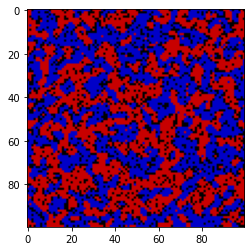

In [8]:
animation = run_model(threshold=0.5, ticks=50000, ticks_per_snapshot=1000)

In [9]:
from IPython.display import HTML
HTML(animation.to_jshtml())

(Übrigens kann man in dem obigen Player die Abspielgeschwindigkeit durch das Drücken auf **+** und **-** verändern.)

## Aufgabe 1

- Lies dir den Code und die zugehörige Beschreibung durch und versuche alles so gut es geht nachzuvollziehen.

- Installiere die Pakete Celluloid und ffmpeg.

- Kopiere den obigen Code des Schelling-Modells in ein Python-Skript und führe diesen aus. Funktioniert es bei dir? 

- Führe die Funktion `run_model()` mit verschiedenen Werten für `threshold` aus. Welchen Einfluss hat der Parameter `threshold` auf den Verlauf der Simulation?


## Aufgabe 2

- Überlege dir eine nützliche Modifikation des Codes, setze diese um und beschreibe ganz kurz, warum du diese Modifikation für sinnvoll erachtest. Mögliche Modifikation des Codes könnten z.B. sein:
    - Man könnte eine Möglichkeit, die Besiedelungsdichte oder die Anzahl der Mitglieder von Gruppe 1 und 2 als Anteilswert angeben zu können, einbauen. Dadurch müsste man beim Ausführen der Simulation nicht vorher selbst berechnen, wie viele Agenten ich aus den jeweiligen Gruppen brauche, um das Grid z.B. zu 90% zu besiedeln und 10% der Zellen unbewohnt zu lassen.
    - Man könnte noch eine dritte oder vierte Gruppe das Grid besiedeln lassen (extrem fortgeschritten wäre es, wenn man eine Möglichkeit einbaut, wie man per Parameter die Anzahl der Gruppen bestimmen könnte)
    - Man könnte die Farben der Agenten ändern.
    - ...


## Aufgabe 3

Im nächste Kapitel wird es darum gehen, ein Simulationsexperiment auf Basis des Schelling-Modells durchzuführen.

- Überlege dir daher, welche Eigenschaften/Dynamiken des Modells *systematisch* innerhalb eines Simulationsexperimentes ausgewertet werden könnten. Denke also darüber nach, welche Eigenschaften des Schelling-Modells man als *unabhängige Variable* innerhalb eines Simulationsexperimentes variieren könnte, um den Effekt dieser unabhängigen Variable auf eine abhängige Variable zu messen.

- Überlege dir, wie man die von dir gewählten abhängige und unabhängige Variable im Modell messen könnte, was man grob am Code verändern müsste und wie ein Simulationsexperiment aufgebaut sein müsste, um den Effekt der abhängigen auf die unabhängige Variable erfassen zu können.